In [3]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 
from matplotlib.patches import Patch
#### PLOT THE DATA #######
SMALL_SIZE = 13.5
MEDIUM_SIZE = 17
BIGGER_SIZE = 23
plt.rcParams["font.family"] = "serif"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


index 0
index 1
index 2
index 3
index 4
index 5
index 6
index 7
index 8
index 9
index 10
index 11
index 12
index 13
index 14
index 15
index 16
index 17
index 18
index 19
index 20
index 21
index 22
index 23
index 24
index 25
index 26
index 27
index 28
index 29
index 30
index 31
index 32
index 33
index 34
index 35
index 36
index 37
index 38
index 39
index 40
index 41
index 42
index 43
index 44
index 45
index 46
index 47
index 48
index 49
index 0
index 1
index 2
index 3
index 4
index 5
index 6
index 7
index 8
index 9
index 10
index 11
index 12
index 13
index 14
index 15
index 16
index 17
index 18
index 19
index 20
index 21
index 22
index 23
index 24
index 25
index 26
index 27
index 28
index 29
index 30
index 31
index 32
index 33
index 34
index 35
index 36
index 37
index 38
index 39
index 40
index 41
index 42
index 43
index 44
index 45
index 46
index 47
index 48
index 49
index 0
index 1
index 2
index 3
index 4
index 5
index 6
index 7
index 8
index 9
index 10
index 11
index 12
index 13
inde

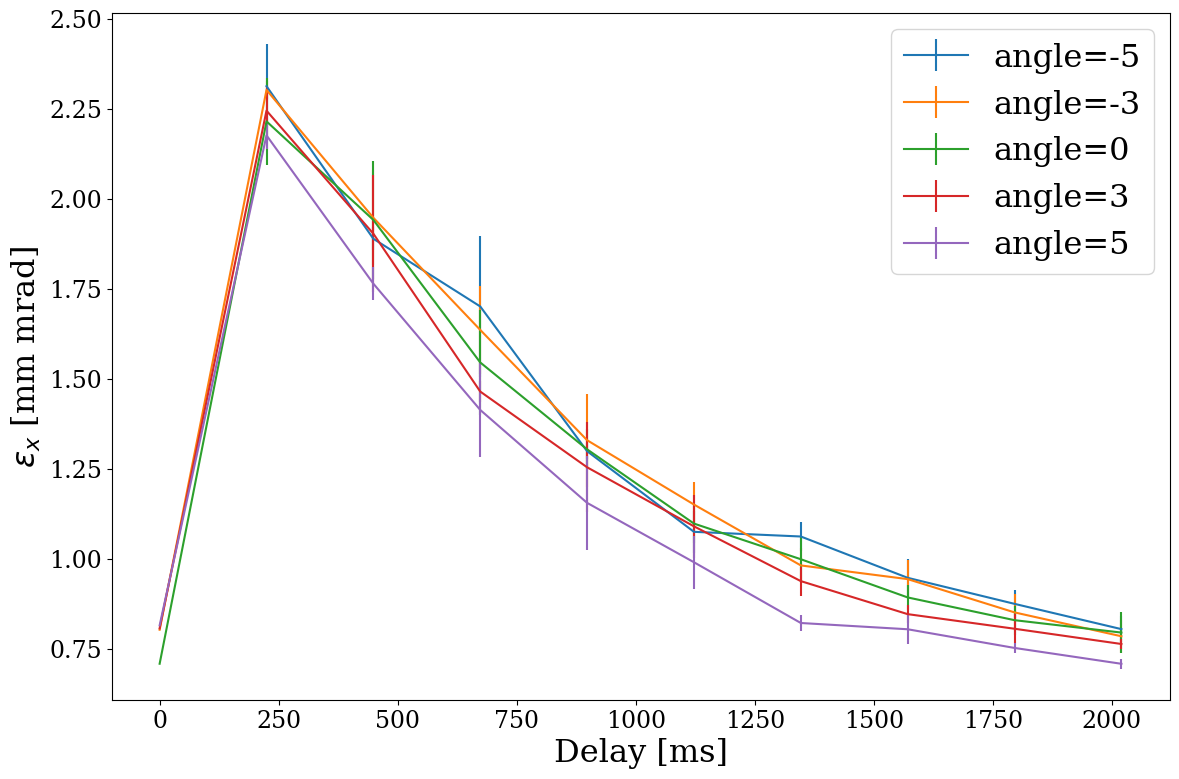

In [4]:
#### Some notes:
'''
Angles and Offsets (of the H- beam) easy/safe to move. 'ELENABEAM/ECOOL-ANGLE-H-mrad'
E_k electrons: at a first order, only need to change  LNR4.ECVCATHLM/REF.DIRECT.V#VALUE
I electrons: need to act, at least, LNR4.ECVGRIDLM/REF.DIRECT.V#VALUE but will probably need to adjust energy as well
-> E_k and I_e are coupled! so you might need to change both at the same time...

The current of the electron, it is in principle measured by LNR4.ECVCOLLM/MEAS.I#VALUE

The current emitted (but not necessarily going into cooling) by the gun, is should be measurable by LNR4.ECVCATHLM/MEAS.I#VALUE

To change the delay of extraction:
AEX.MW-RF/Delay#delay
mind that with 10 ms (10 ticks) delay, you extract approximately at injection

To "not start" the e-cooling process, just set to False
AX.DK3-EC/OutEnable#outEnabled

To delay the start of cooling one can increase the value of
AX.DK3-EC/Delay#delay
Note: the default value=200 1kHz ticks means start at C time 9400, i.e. about 100 ms before our "second injection"


'''



############### Initial imports
# from pyjapcscout import PyJapcScout
from datascout import dict_to_parquet
from datascout import parquet_to_dict
from datascout import unixtime_to_string
import numpy as np
import datascout
import re
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter



data=np.load('V_bumps/bumps.npz')

n_steps=data['n_steps']
num_samples=data['num_samples']
delay_list=data['delay_list']
repeated_delay=data['repeated_delay']
bumps_list=data['bumps_list']
#horiztonal plane

beta_x = 7.6 #m
beta_y = 1.3 #m

plt.figure(figsize=(12, 8))

for angle_values in bumps_list:

    vertical_list = []
    horizontal_list = []

    vertical_integral_list = []
    horizontal_integral_list = []

    for i in range(len(repeated_delay)):
        print('index', i)
        data_to_look_at = parquet_to_dict(f'V_bumps/bumps{angle_values}/{i}.parquet')
        # BPM = data_to_look_at['LNE00.BSGW.0008/Acquisition']['value']
        BPM = data_to_look_at['LNE50.BSGW.5020/Acquisition']['value']
        vertical = BPM['sigma'][0]
        horizontal = BPM['sigma'][1]

        vertical_list.append(vertical)
        horizontal_list.append(horizontal)

        vertical_int = BPM['rawIntegrals'][0]
        horizontal_int = BPM['rawIntegrals'][1]

        vertical_integral_list.append(vertical_int)
        horizontal_integral_list.append(horizontal_int)

    filter_threshold = 10
    integral_threshold = 5000

    # filter_horizontal = [sigma_x for sigma_x in horizontal_list if 0 < sigma_x < filter_threshold]
    # filtered_delay_h = [delay_x for idx, delay_x in enumerate(repeated_delay) if
    #                     0 < horizontal_list[idx] < filter_threshold]

    filter_horizontal=[]
    filter_horizontal_intensity=[]
    filtered_delay_h=[]

    filter_vertical=[]
    filter_vertical_intensity=[]
    filtered_delay_v=[]

    for i in range(len(horizontal_list)):
        sigma_x=horizontal_list[i]
        sigma_y=vertical_list[i]
        integral_x=horizontal_integral_list[i]
        integral_y=vertical_integral_list[i]
        condition_sigma_x=sigma_x < filter_threshold
        condition_sigma_y=sigma_y < filter_threshold
        condition_intensity_x=integral_x > integral_threshold
        condition_intensity_y=integral_y > integral_threshold

        if condition_sigma_x & condition_sigma_y & condition_intensity_x & condition_intensity_y:
            filter_horizontal.append(sigma_x**2/beta_x)
            filter_vertical.append(sigma_y**2/beta_y)
            filter_horizontal_intensity.append(integral_x)
            filter_vertical_intensity.append(integral_y)
            filtered_delay_h.append(repeated_delay[i])
            filtered_delay_v.append(repeated_delay[i])
            

    diff_h=np.diff(filtered_delay_h)
    diff_v=np.diff(filtered_delay_v)

    indices_h = np.where(diff_h != 0)[0]+1
    indices_v = np.where(diff_v != 0)[0]+1

    sigma_h_groups = np.split(filter_horizontal,indices_h)
    sigma_v_groups = np.split(filter_vertical,indices_v)

    h_delay_unique=np.unique(filtered_delay_h)
    v_delay_unique=np.unique(filtered_delay_v)

    means_h=[np.mean(group) for group in  sigma_h_groups]
    means_v=[np.mean(group) for group in sigma_v_groups]

    stds_h=[np.std(group) for group in sigma_h_groups]
    stds_v=[np.std(group) for group in sigma_v_groups]
    
    np.savez(f'results/bump_y/horizontal/ELENA_bump{angle_values}.npz',
              h_delay_unique=h_delay_unique, means_h=means_h, stds_h=stds_h, angle_values=angle_values)
    np.savez(f'results/bump_y/vertical/ELENA_bump{angle_values}.npz',
              v_delay_unique=v_delay_unique, means_v=means_v, stds_v=stds_v, angle_values=angle_values)

    plt.errorbar(h_delay_unique,means_h,yerr=stds_h,label=f'angle={angle_values}')
    #plt.errorbar(v_delay_unique,means_v,yerr=stds_v,label='vertical')
    plt.xlabel('Delay [ms]')
    plt.ylabel('$\epsilon_x$ [mm mrad]')
    plt.legend()
    plt.tight_layout()
plt.show()
